In [2]:
import grizli
import numpy as np
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits
from collections import OrderedDict
import astropy.wcs as pywcs
import pysynphot as S
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1, as_cmap=True)

Define Function to change flux into magnitudes

In [3]:
def Mag(band):
    magnitude=25-2.5*np.log10(band)
    return magnitude

Create initial model

In [4]:
pad=100
grism_input='/Users/Vince.ec/Clear_data/flt_files/icxt52i0q_flt.fits'
reference_image='/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits'
segment_map='/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits'

# grism_input='/Users/Vince.ec/Clear_data/flt_files/icxt30s0q_flt.fits'
# reference_image='/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits'
# segment_map='/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'

sim_g102 = grizli.model.GrismFLT(grism_file=grism_input,verbose=True,ref_file=reference_image,seg_file=segment_map,force_grism='G102',pad=pad)

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


Image cutout: x=slice(9128, 12621, None), y=slice(8733, 11913, None)
/Users/Vince.ec/Clear_data/flt_files/icxt52i0q_flt.fits / blot reference /Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits[0]
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pi

Read in catalogs

In [5]:
ref_cat=Table.read(fits.open('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.3.cat.FITS')[1])
# ref_cat=Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii')

sim_cat=sim_g102.blot_catalog(ref_cat,sextractor=False)

Select objects

In [6]:
sim_g102.compute_full_model(ids=sim_cat['id'], mags=Mag(sim_cat['f_F125W']))

Locate object

In [7]:
gal_id =21156
gal_id2 = 19513
# gal_id=40597
# gal_id=40891
obj_mag = Mag(ref_cat['f_F125W'][np.argwhere(ref_cat['id']==gal_id)])
obj_mag2 = Mag(ref_cat['f_F125W'][np.argwhere(ref_cat['id']==gal_id2)])

print('ID:%d, mag=%.2f' %(gal_id, obj_mag))
print('ID:%d, mag=%.2f' %(gal_id2, obj_mag2))
print('ra:%s, dec=%s' % (ref_cat['ra'][np.argwhere(ref_cat['id']==gal_id)], ref_cat['dec'][np.argwhere(ref_cat['id']==gal_id)]))
print('ra:%s, dec=%s' % (ref_cat['ra'][np.argwhere(ref_cat['id']==gal_id2)], ref_cat['dec'][np.argwhere(ref_cat['id']==gal_id2)]))

ID:21156, mag=20.87
ID:19513, mag=21.31
ra:  ra [1]  
----------
189.239409, dec= dec [1] 
---------
62.247548
ra:  ra [1] 
---------
189.24101, dec= dec [1] 
---------
62.238259


Create cutout

In [8]:
beam_g102 = grizli.model.BeamCutout(sim_g102, sim_g102.object_dispersers[gal_id]['A'])
beam_g102_2 = grizli.model.BeamCutout(sim_g102, sim_g102.object_dispersers[gal_id2]['A'])
print 'cutout done'

cutout done


Simulate spectra

In [9]:
wave, fl = np.array(Readfile('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.027_a3.4_t8.86_spec.dat'))

## redshift spec
spec = S.ArraySpectrum(wave, fl, fluxunits='flam')
spec = spec.redshift(1.25).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f125w'))
spec.convert('flam')

## Compute the models
beam_g102.compute_model(spectrum_1d=[spec.wave,spec.flux])

## Extractions the model
w, f, e = beam_g102.beam.optimal_extract(beam_g102.model,bin=0)

## Get sensitivity function
fwv, ffl = [beam_g102.beam.lam, beam_g102.beam.sensitivity / np.max(beam_g102.beam.sensitivity)]
filt = interp1d(fwv, ffl)

## Clip model to fit in interpolation
clip = []
for iii in range(len(w)):
    if fwv[0] < w[iii] < fwv[-1]:
        clip.append(iii)

w = w[clip]
f = f[clip]

f /= filt(w)

ID1=[U for U in range(len(w)) if 7900 < w[U] <11300]
#######
#######
## Compute the models
beam_g102_2.compute_model(spectrum_1d=[spec.wave,spec.flux])

## Extractions the model
w2, f2, e2 = beam_g102_2.beam.optimal_extract(beam_g102_2.model,bin=0)

## Get sensitivity function
fwv2, ffl2 = [beam_g102_2.beam.lam, beam_g102_2.beam.sensitivity / np.max(beam_g102_2.beam.sensitivity)]
filt2 = interp1d(fwv2, ffl2)

## Clip model to fit in interpolation
clip = []
for iii in range(len(w2)):
    if fwv2[0] < w2[iii] < fwv2[-1]:
        clip.append(iii)

w2 = w2[clip]
f2 = f2[clip]

f2 /= filt2(w2)

ID2=[U for U in range(len(w2)) if 7900 < w2[U] <11300]

Plot results

56


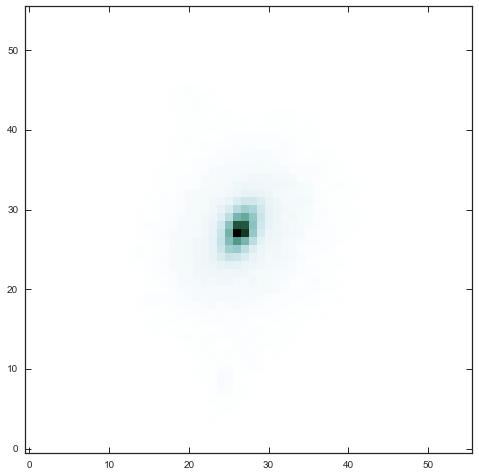

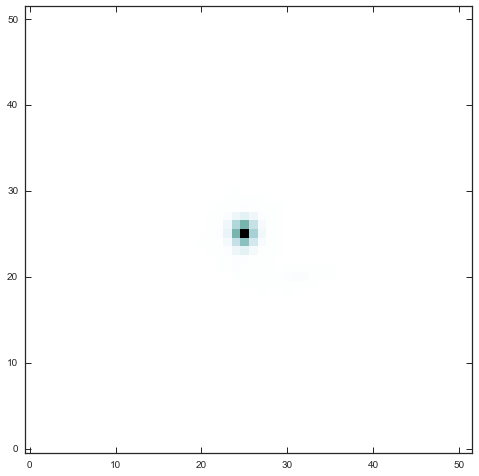

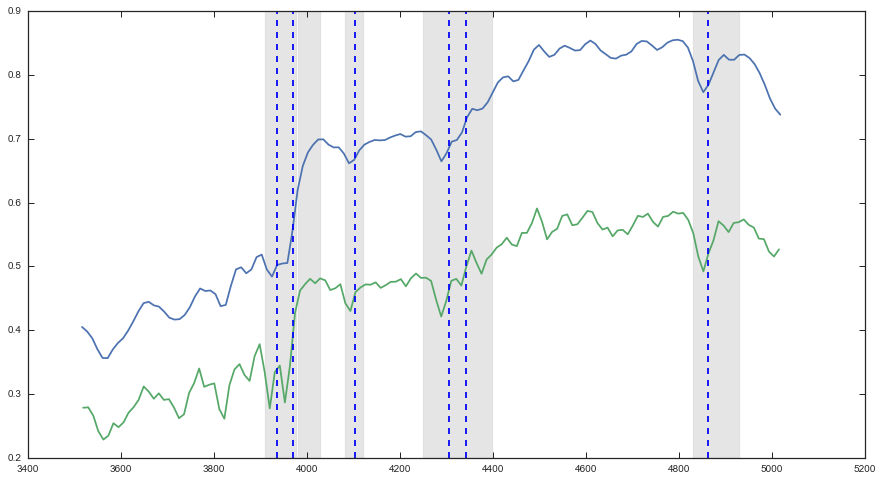

In [10]:
%matplotlib inline

print len(beam_g102.beam.direct)

###show cutout
plt.figure(figsize=[8,8])
plt.imshow(beam_g102.beam.direct*(beam_g102.beam.seg == gal_id), interpolation='Nearest', cmap=colmap, origin='lower')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.imshow(beam_g102_2.beam.direct*(beam_g102_2.beam.seg == gal_id2), interpolation='Nearest', cmap=colmap, origin='lower')
plt.show()
plt.close()

###plot spectra
plt.figure(figsize=[15,8])
plt.plot(w[ID1]/2.25,f[ID1])
plt.plot(w2[ID2]/2.25,f2[ID2])
plt.axvline(3934.777,linestyle='--')
plt.axvline(3969.588,linestyle='--')
plt.axvline(4102.89,linestyle='--')
plt.axvline(4305.61,linestyle='--')
plt.axvline(4341.68,linestyle='--')
plt.axvline(4862.68,linestyle='--')
plt.axvspan(3910, 3979, color='k', alpha=.1)
plt.axvspan(3981, 4030, color='k', alpha=.1)
plt.axvspan(4082, 4122, color='k', alpha=.1)
plt.axvspan(4250, 4400, color='k', alpha=.1)
plt.axvspan(4830, 4930, color='k', alpha=.1)
plt.show()
plt.close()